In [5]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = r'C:\Users\hp\Desktop\Covid-Detection\Train'
valid_path = r'C:\Users\hp\Desktop\Covid-Detection\Val'


In [7]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [9]:
# useful for getting number of classes
folders = glob(train_path)

In [10]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='sigmoid')(x)

In [11]:
# create a model object
model = Model(vgg.input, prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'binary')


Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [16]:
# implementing early stopping and model check point 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [21]:
# fit the model
model_history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=8,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)
# callbacks=[es,mc]


Epoch 1/8
4/4 [==============================] - 76s 19s/step - loss: 0.1532 - accuracy: 0.9598 - val_loss: 0.0266 - val_accuracy: 0.9833
Epoch 2/8
4/4 [==============================] - 76s 19s/step - loss: 0.0912 - accuracy: 0.9732 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 3/8
4/4 [==============================] - 74s 19s/step - loss: 0.0544 - accuracy: 0.9911 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 4/8
4/4 [==============================] - 75s 19s/step - loss: 0.0600 - accuracy: 0.9821 - val_loss: 0.0233 - val_accuracy: 0.9833
Epoch 5/8
4/4 [==============================] - 75s 19s/step - loss: 0.0641 - accuracy: 0.9866 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 6/8
4/4 [==============================] - 74s 21s/step - loss: 0.0398 - accuracy: 0.9911 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 7/8
4/4 [==============================] - 73s 21s/step - loss: 0.0524 - accuracy: 0.9866 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 8/8
4/4 [===================

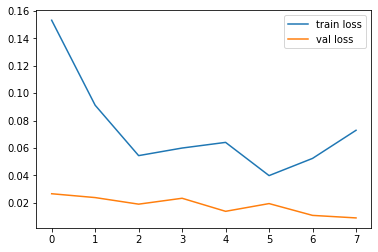

<Figure size 432x288 with 0 Axes>

In [22]:
# loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


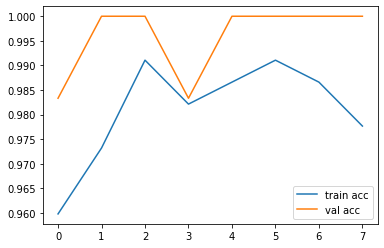

<Figure size 432x288 with 0 Axes>

In [24]:
# accuracies
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
import tensorflow as tf

from keras.models import load_model

model.save('transfer_learning_model.h5')